Generating Data

In [24]:
import numpy as np
import random
import torch

def generate(n, p):
    numbers = [p-1, p]
    probabilities = [0.5, 0.5]
    data = []

    for i in range(n):
        arr = np.zeros((p+1, p+1))
        x = np.random.choice(numbers, size=1, p=probabilities)
        
        arr[x[0]][0] = 1
        arr[x[0]][p] = 1
       
        num = []
        for j in range(p-1):
            num.append(random.randint(0, p-2))

        num.sort()

        for j in range(1, p):
            arr[num[j-1]][j] = 1

        arr = arr.T
        data.append(arr)
        
    data = np.array(data)
    data = torch.from_numpy(data).float()
    return data

data = generate(2000, 100)

Splitting Data

In [25]:
#split data into x_train and y_train
x_train = data[:, :-1, :]
y_train = data[:, -1, :]

print(x_train.shape)
print(y_train.shape)

torch.Size([2000, 100, 101])
torch.Size([2000, 101])


RNN Class

In [27]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        h = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h)
        out = self.linear(out[:, -1, :])
        
        return out

LSTM Class

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        h = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h, c))
        out = self.linear(out[:, -1, :])
        
        return out

Train function

In [5]:
#train the model
def train_model(model, criterion, optimizer, num_epochs, batch_size):
    loss_list = []
    epoch_list = []
    
    for epoch in range(num_epochs): 
        sum = 0
        for i in range(int(x_train.shape[0] / batch_size)):
            optimizer.zero_grad()

            inputs = x_train[i * batch_size:(i+1) * batch_size]
            labels = y_train[i * batch_size:(i+1) * batch_size]

            outputs = model(inputs)
            #print(outputs.shape, labels.shape)
            loss = criterion(outputs, labels)
            sum += loss.item()

            loss.backward()
            optimizer.step()
        
        loss_list.append(sum / x_train.shape[0])
        if (epoch + 1) % 10 == 0:
                print('Epoch [{}/{}], Loss: {:.6f}'.format(epoch + 1, num_epochs, sum / x_train.shape[0]))

        epoch_list.append(epoch + 1)

    return loss_list, epoch_list

RNN

Epoch [10/100], Loss: 0.034786
Epoch [20/100], Loss: 0.034702
Epoch [30/100], Loss: 0.034662
Epoch [40/100], Loss: 0.034627
Epoch [50/100], Loss: 0.000127
Epoch [60/100], Loss: 0.000031
Epoch [70/100], Loss: 0.000013
Epoch [80/100], Loss: 0.000007
Epoch [90/100], Loss: 0.000004
Epoch [100/100], Loss: 0.000002


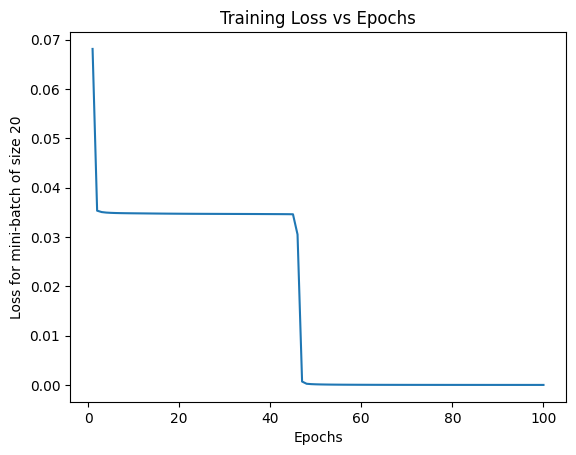

In [31]:
#pass input to RNN
import matplotlib.pyplot as plt
input_size = 101
hidden_size = 64
output_size = 101

rnn_model = RNN(input_size, hidden_size, output_size, num_layers=1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

#train the model
loss_list, epoch_list =  train_model(rnn_model, criterion, optimizer, num_epochs=100, batch_size=20)
plt.plot(epoch_list, loss_list)
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss for mini-batch of size 20')
plt.show()

LSTM

Epoch [10/100], Loss: 0.034758
Epoch [20/100], Loss: 0.034681
Epoch [30/100], Loss: 0.034624
Epoch [40/100], Loss: 0.034581
Epoch [50/100], Loss: 0.034544
Epoch [60/100], Loss: 0.034511
Epoch [70/100], Loss: 0.034484
Epoch [80/100], Loss: 0.034457
Epoch [90/100], Loss: 0.034405
Epoch [100/100], Loss: 0.034257


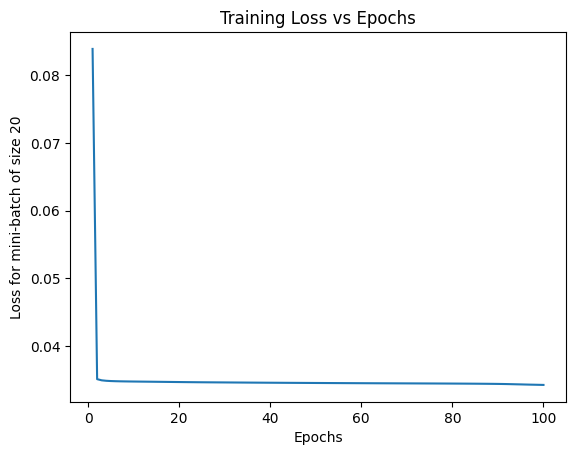

In [32]:
#pass input to LSTM
input_size = 101
hidden_size = 64
output_size = 101

lstm_model = LSTM(input_size, hidden_size, output_size, num_layers=1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

#train the model
loss_list, epoch_list =  train_model(lstm_model, criterion, optimizer, num_epochs=100, batch_size=20)
plt.plot(epoch_list, loss_list)
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss for mini-batch of size 20')
plt.show()

Generate test data

In [7]:
test_data = generate(3000, 100)

#split data into x_test and y_test
x_test = test_data[:, :-1, :]
y_test = test_data[:, -1, :]

print(x_test.shape)
print(y_test.shape)

torch.Size([3000, 100, 101])
torch.Size([3000, 101])


Test function

In [35]:
#test the model
from sklearn.metrics import accuracy_score
def test_model(model, criterion):
    with torch.no_grad():
        outputs = model(x_test)
        loss = criterion(outputs, y_test)
        print('Test Loss: {:.6f}'.format(loss.item()))

        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.tolist()

        y_test_flat = y_test.argmax(dim=1).tolist()

        print('Accuracy: {:.6f}'.format(accuracy_score(y_test_flat, predicted)))    

RNN

In [38]:
criterion = nn.CrossEntropyLoss()
test_model(rnn_model, criterion)

#calculate no of wrong predictions
def wrong_predictions(model):
    count = 0
    for i in range(10):
        test_data = generate(3000, 100)
        with torch.no_grad():
            x_test = test_data[:, :-1, :]
            y_test = test_data[:, -1, :]

            outputs = model(x_test)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.tolist()

            y_test_flat = y_test.argmax(dim=1).tolist()

            for i in range(len(predicted)):
                if predicted[i] != y_test_flat[i]:
                    count += 1

    print('No of wrong predictions: ', count/10)

wrong_predictions(rnn_model)

Test Loss: 0.000045
Accuracy: 1.000000
No of wrong predictions:  0.0


LSTM

In [39]:
criterion = nn.CrossEntropyLoss()
test_model(lstm_model, criterion)

wrong_predictions(lstm_model)

Test Loss: 0.699133
Accuracy: 0.508667
No of wrong predictions:  1500.1


Architecture used:
- Input size: 101
- Hidden size: 64
- Output size: 101
- No. of layers: 1
- Loss: CrossEntropy
- Optimizer: Adam
- Learning rate: 0.001
- Epochs: 100
- Batch_size: 20
- Time steps: 100
- No of training samples: 2000

Result:
- RNN has a better accuracy (1) than LSTM (0.5)